In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from data_swerick import create_dataset_swerick
from evaluation import evaluation_task
import preprocessing
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def insert_random_mask(batch,data_collator):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [4]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = preprocessing.create_model_MLM(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [6]:
#datasest
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)


DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 12463
    })
    test: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2629
    })
})


In [7]:
tokenized_datasets =preprocessing.tokenize_dataset(swerick_dataset,tokenizer)

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 12463
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 2629
    })
})

In [8]:
chunk_size = 128

In [9]:
lm_datasets = preprocessing.grouping_dataset(tokenized_datasets,chunk_size)
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 3681534
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 761125
    })
})

In [10]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [11]:
data_valid={"valid":"swerick_data_random_valid.pkl"}
valid_dataset = load_dataset("pandas",data_files=data_valid) 
valid_dataset =preprocessing.tokenize_dataset(valid_dataset,tokenizer)
valid_dataset=preprocessing.grouping_dataset(valid_dataset,chunk_size)

valid_dataset

Map:   0%|          | 0/2629 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [16]:
with open("valid_dataset.pkl","wb") as f:
     pickle.dump(valid_dataset,f)

In [12]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

DatasetDict({
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 761125
    })
})

In [13]:
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)

trial with a manual implementation

In [14]:
print(lm_datasets)

lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])


eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)

print(eval_dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 3681534
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 761125
    })
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 761125
})


In [15]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to("cpu") for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
print("ok")

#for batch in train_dataloader:
    #batch = to_device(batch)

#for batch in eval_dataloader:
    #batch = to_device(batch)




print(eval_dataloader.dataset)

ok
ok
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 761125
})


In [ ]:
print(train_dataloader.dataset)
print(eval_dataloader)

for batch in eval_dataloader:
    print(batch["input_ids"].device)
    break

In [ ]:
print(len(train_dataloader))

In [ ]:
def get_dataloader():
    train =DataLoader(
    lm_dataset_bis["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator)
    train = [inputs.to(device) for inputs in train_dataloader]
    return train


for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break

for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break



In [17]:
model_bis = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_bis=model_bis.to("cpu")

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_bis.eval()

total_loss = 0.0  # Variable to accumulate total loss

for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        outputs = model_bis(**batch)
    loss = outputs.loss
    total_loss += loss.item()   # Accumulate the batch loss

# Calculate the average loss
average_loss = total_loss / len(eval_dataloader)

print(f"Initial Loss: {average_loss}")

In [ ]:

optimizer = AdamW(model_bis.parameters(), lr=1.3e-5)
print(optimizer)

In [ ]:
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
progress_bar = tqdm(range(num_training_steps))

losses_train=[]
losses_test=[]
#train_dataloader = get_dataloader()
for epoch in range(num_train_epochs):
    # Training
    model_bis.train()
    print(next(model_bis.parameters()).device)
    print(epoch)
    params_before_optimization = [param.data.clone() for param in model_bis.parameters()]
    total_loss_train = 0.0 
    train_dataloader = get_dataloader()

    for batch in train_dataloader:
        outputs = model_bis(**batch)
        loss = outputs.loss
        total_loss_train += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        params_after_optimization = [param.data for param in model_bis.parameters()]
        parameters_changed = any((param_before != param_after).any() for param_before, param_after in zip(params_before_optimization, params_after_optimization))
        #if parameters_changed==True :
             # print(parameters_changed) 
        progress_bar.update(1)

    losses_train.append(total_loss_train/len(train_dataloader))
    print("losses_train",losses_train)

    # Evaluation
    model_bis.eval()
    losses=[]
    total_loss_eval=0.0
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model_bis(**batch)

        loss = outputs.loss
        losses.append(loss.repeat(batch_size))
        total_loss_eval +=loss.item()


    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
       perplexity = float("inf")

    losses_test.append(total_loss_eval/len(eval_dataloader))


    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    print("losses_test",losses_test)

print("epoch",num_train_epochs)
plt.plot(range(num_train_epochs),losses_train,label="train Loss")

plt.plot(range(num_train_epochs),losses_test,label="test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

            

In [ ]:
print(losses_train)
print(losses_test)

In [ ]:
file_path = "finetuning_manual"
model_bis.save_pretrained(file_path)
tokenizer.save_pretrained(file_path)

In [ ]:
import pickle

file_name = "losses.pkl"

with open(file_name, 'wb') as f:
    pickle.dump({'losses_train': losses_train, 'losses_test': losses_test}, f)


In [ ]:
from transformers import pipeline
pipe = pipeline(task="fill-mask", model="./test_model")

In [15]:
model_long=AutoModelForMaskedLM.from_pretrained("./finetuning_hugging-finetuned-imdb/checkpoint-259384")
model_long=model_long.to("cpu")

In [25]:
model=AutoModelForMaskedLM.from_pretrained("./test_model")
model=model.to(device)

In [15]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_python-finetuned-imdb/checkpoint-920384")
model_hugging_face=model_hugging_face.to(device)

In [27]:
model_kb=AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
correct_predictions = 0
total_predictions =0
model.eval()
device="cpu"
for step,batch in enumerate(train_dataloader):
    batch["input_ids"] = batch["input_ids"].to(device)
    batch["attention_mask"] = batch["attention_mask"].to(device)
    batch["labels"]= batch["labels"].to(device)
    indices_tokens_masked = []
    for labels in batch["labels"]:
        indices_tokens_masked.append(torch.nonzero(labels !=-100).flatten().tolist())
    output=model_kb(**batch)
    print(output.loss)
    predicted_token_ids = torch.argmax(output.logits,dim=-1)
    print(predicted_token_ids)

    for i in range(len(indices_tokens_masked)):
        for j in indices_tokens_masked[i]:
            total_predictions +=1
            if batch["labels"][i][j] == predicted_token_ids[i][j]:
                correct_predictions += 1

     # Créer un masque pour filtrer les étiquettes
    mask = (batch["labels"] != -100)

    # Appliquer le masque pour obtenir les prédictions et les étiquettes filtrées
    filtered_preds = predicted_token_ids[mask]
    filtered_labels = batch["labels"][mask]

    # Calculer et afficher l'accuracy
    batch_acc = torch.mean((filtered_preds == filtered_labels).float())
    print("Batch Accuracy:", batch_acc.item())
    break

print("acuraccy :",correct_predictions/total_predictions)
        



tensor(8.2863, grad_fn=<NllLossBackward0>)
tensor([[    7,   109,   252,  ...,  3116,     7, 21264],
        [    7, 49686,    19,  ..., 38858,   145, 17675],
        [    7,  7414, 13048,  ...,  5847, 26006,   268],
        ...,
        [    7,     7, 33423,  ...,   126, 20035,  1057],
        [    7,   148,   512,  ...,  4838,  7541,     7],
        [   19,    98,    19,  ...,    52,     1,     7]])
Batch Accuracy: 0.19413287937641144
acuraccy : 0.19413287316652286


In [17]:
device

device(type='cpu')

In [16]:
evaluation_task(model_hugging_face,eval_dataloader)

Trainer evaluation....


/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/11893 [00:00<?, ?it/s]

>>> Perplexity: 2.17
Manual perplexity...
 Perplexity: 2.1704916809154797
Accuracy...
Accuracy: 0.8261846081389651


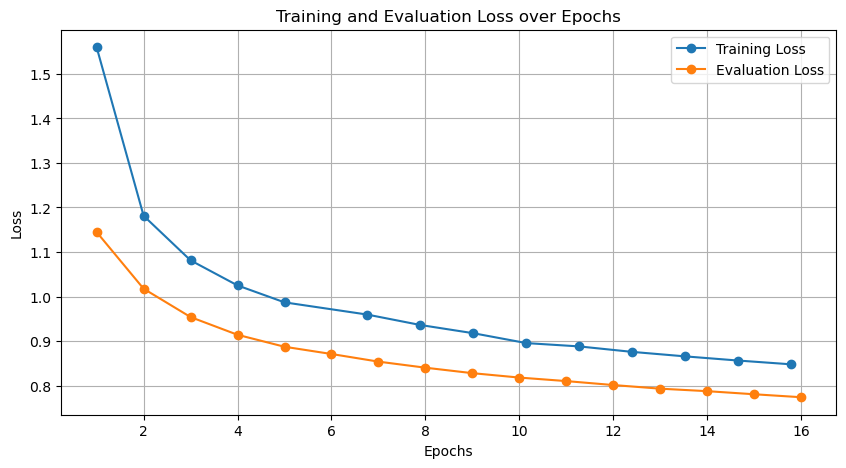

In [16]:
import json
import matplotlib.pyplot as plt

# Charger les données à partir du fichier JSON
with open('/home/laurinemeier/swerick/finetuning_hugging_python-finetuned-imdb/checkpoint-920384/trainer_state.json', 'r') as file:
    data = json.load(file)

train_loss = []
eval_loss = []
epoch_train = []
epoch_test=[]

for entry in data['log_history']:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        epoch_train.append((entry['epoch']))
    elif 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))

plt.figure(figsize=(10, 5))
plt.plot(epoch_train, train_loss, label='Training Loss', marker='o')
plt.plot(epoch_test, eval_loss, label='Evaluation Loss', marker='o')
plt.title('Training and Evaluation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
batch_size = 64
num_epochs=100
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
print(len(lm_datasets["train"]) // batch_size)
model_name = model_checkpoint.split("/")[-1]

trainer = preprocessing.create_trainer(model,model_name,batch_size,logging_steps,train_dataset=lm_datasets["train"],eval_dataset=lm_datasets["test"],data_collator=data_collator,tokenizer=tokenizer,num_epochs=100)

trainer.evaluate()

57523


/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/11893 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 9.21 GiB. GPU 0 has a total capacity of 23.67 GiB of which 8.59 GiB is free. Including non-PyTorch memory, this process has 14.68 GiB memory in use. Of the allocated memory 9.69 GiB is allocated by PyTorch, and 4.68 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Get the training and validation losses,
trainer = 
print(type(trainer.state.log_history))
print(len(trainer.state.log_history))
train_losses=[]
test_losses=[]
for i in range(len(trainer.state.log_history)//2):
   train_losses.append(trainer.state.log_history[2*i]["loss"])
   test_losses.append(trainer.state.log_history[2*i+1]["eva_loss"])
#eval_losses = trainer.state.log_history[\"eval_loss\"]

#print(train_losses)

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
evaluation_task(model_kb,eval_dataloader)

Trainer evaluation....


  0%|          | 0/16484 [00:00<?, ?it/s]

>>> Perplexity: 5813.28
Manual perplexity...
 Perplexity: 5814.432395049958
Accuracy...
Accuracy: 0.18456963747366367


In [20]:
evaluation_task(model,eval_dataloader)

Trainer evaluation....


  0%|          | 0/16484 [00:00<?, ?it/s]

>>> Perplexity: 5363.19
Manual perplexity...
 Perplexity: 5364.880164258874
Accuracy...
Accuracy: 0.23634023447799532


In [29]:


# Define your training arguments
training_args = TrainingArguments(
    output_dir=f"{model_long.config.name_or_path}-imdb",
    per_device_eval_batch_size=64,
    # Add other training arguments as needed
    logging_steps=892,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    no_cuda=True
)
print(training_args.device)
# Create the Trainer object
trainer = Trainer(
    model=model_long,
    args=training_args,
    eval_dataset=eval_dataset
)

result = trainer.evaluate()

/home/laurinemeier/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1399: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/home/laurinemeier/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


cpu


  0%|          | 0/195 [00:00<?, ?it/s]

In [30]:
result


{'eval_loss': 0.8190011382102966,
 'eval_runtime': 1639.8287,
 'eval_samples_per_second': 7.575,
 'eval_steps_per_second': 0.119}

In [33]:
math.exp(result['eval_loss'])

2.2682330542912186